# Genentech Cervical Cancer Screening Project

This IPython notebook has been the foundation of most of the modelling work done throughout the competition. 

This will **NOT** reproduce the winning solution, which is a far more complex ensemble of models, some of which run for days, but will provide an example of a model that will score .9648 in cross validation and ~.9629 on the Private leaderboard.

#### Environment

- 128GB RAM
- Python Anaconda
- XGB


#### Generate the data (final version v9)

v9 (final version) of the data is generated using **feature engineering SQL.sql** in a Hadoop environment. This will generate only the dense portion of the dataset (~400 features) in a .csv format that will be read in memory through Pandas.

Sparse features need to be one-hot-encoded using scikit learn CountVectorizer with the following setting:

tf\_vectorizer = CountVectorizer(min\_df=50, max_df=0.9,stop_words='english',token\_pattern=u'[0-9A-Za-z\_]{1,}',ngram\_range=(1,1))

There is a total of 42 files (21 for train, 21 for test) that need to be encoded. All of these tables will be read into memory using scikit learn joblib.

In [1]:
import glob
import os
import sys
from sklearn.cross_validation import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import ensemble, linear_model
import pylab as pyplot
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.externals import joblib
from scipy.sparse import hstack, csr_matrix
from sklearn.datasets import dump_svmlight_file
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
%matplotlib inline
os.chdir('/data')

In [2]:
#-------------------------------------------------------------------------
# SETTING
#-------------------------------------------------------------------------

SEED = 42
TEST = True #use True if you want to actually make a submission, False if you only need to do cross validation

In [3]:
#-------------------------------------------------------------------------
# DEFINITIONS
#-------------------------------------------------------------------------

def cvloopxgbm(X, y, n=1, test_size=0.2):
    """
    Cross validation loop for validation purposes
    
    """
    M = []
    k=1     
    
    kf = StratifiedShuffleSplit(y, n_iter=n, 
                                test_size=test_size, 
                                random_state=SEED)

    for train_index, test_index in kf:
        preds = np.zeros(len(test_index))
        xg_train = xgb.DMatrix(X[train_index], label=y[train_index])
        xg_test = xgb.DMatrix(X[test_index], label=y[test_index])
        watchlist = [(xg_train,'train'), (xg_test, 'test')]
    
        bst = xgb.train(plst, xg_train, num_round, watchlist, early_stopping_rounds=15 )
        pr = bst.predict(xg_test)
        print ""
        m = roc_auc_score(y[test_index],pr)
        print "Iteration %i of %i - ROC: %.4f" %(k,n,m)
        
        M.append(m)
        k += 1
    
    M = np.array(M)
    
    print "Final ROC: Avg = %.4f, std = %.4f" % (M.mean(), M.std()) 
    return bst.best_iteration
      

## Read Data From CSV and manipulate

In [4]:
train = pd.read_csv('train_v9.csv')
train.columns = [i.split('.')[1] for i in train.columns.values]

In [5]:
if TEST:
    test = pd.read_csv('test_v9.csv')
    test.columns = [i.split('.')[1] for i in test.columns.values]

In [6]:
train.shape

(1157817, 716)

In [7]:
if TEST:
    print test.shape

(1701813, 715)


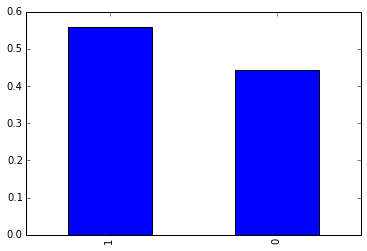

In [8]:
train.is_screener.value_counts(normalize=True).plot(kind="bar")

In [9]:
#fill nulls with 0
train.fillna(0,inplace=True)

In [10]:
if TEST:
    test.fillna(0,inplace=True)

In [11]:
# set up test submission IDs
if TEST:
    pred_df = test[['patient_id']]
    pred_df['prediction'] = np.zeros(test.shape[0])

In [12]:
y = train.is_screener.values

In [13]:
y.mean()

0.55778503856827111

In [14]:
#cv ids
cvpred_df = train[['patient_id']]
cvpred_df['prediction'] = np.zeros(train.shape[0])

In [15]:
#remove extra patient ids generated by the Impala joining process
cols = train.columns.values
keys = [col for col in cols if 'key_' in col]
ccs = [col for col in cols if 'ccs4' in col]
print keys
removeCols = keys + ['patient_id','is_screener','patient_gender']
print removeCols

['key_gj_feats_rx_head', 'key_gj_feats_spec', 'key_gj_feats_specialties', 'key_gj_feats_top_procs', 'key_gj_feats_top_procs_all', 'key_gj_feats_top_dx', 'key_gj_feats_top_dx_all', 'key_gj_feats_leak_det', 'key_gj_feats_leak_all', 'key_gj_feats_target', 'key_gj_feats_procdx_grouped', 'key_gj_feats_provs', 'key_gj_feats_combo_target', 'key_gj_feats_leak_across', 'key_gj_feats_mb_target', 'key_gj_feats_uber_agg_s50', 'key_gj_feats_leak_across_ct', 'key_gj_feats_trg_pos', 'key_gj_feats_leak_sd', 'key_gj_feats_leak_specproc', 'key_gj_feats_leakage_v2', 'key_gj_feats_leak_across2', 'key_gj_feats_leak_across_ct2', 'key_gj_feats_leak_specproc2', 'key_gj_feats_leak_across3', 'key_gj_feats_leak_across_ct3', 'key_gj_feats_leak_specproc3']
['key_gj_feats_rx_head', 'key_gj_feats_spec', 'key_gj_feats_specialties', 'key_gj_feats_top_procs', 'key_gj_feats_top_procs_all', 'key_gj_feats_top_dx', 'key_gj_feats_top_dx_all', 'key_gj_feats_leak_det', 'key_gj_feats_leak_all', 'key_gj_feats_target', 'key_gj_f

In [16]:
train.drop(removeCols,inplace=True,axis=1)
cols = train.columns.values

In [17]:
if TEST:
    cols = test.columns.values
    keys = [col for col in cols if 'key_' in col]
    print keys
    removeCols = keys + ['patient_id','patient_gender']
    print removeCols

['key_gj_feats_rx_head', 'key_gj_feats_spec', 'key_gj_feats_specialties', 'key_gj_feats_top_procs', 'key_gj_feats_top_procs_all', 'key_gj_feats_top_dx', 'key_gj_feats_top_dx_all', 'key_gj_feats_leak_det', 'key_gj_feats_leak_all', 'key_gj_feats_target', 'key_gj_feats_procdx_grouped', 'key_gj_feats_provs', 'key_gj_feats_combo_target', 'key_gj_feats_leak_across', 'key_gj_feats_mb_target', 'key_gj_feats_uber_agg_s50', 'key_gj_feats_leak_across_ct', 'key_gj_feats_trg_pos', 'key_gj_feats_leak_sd', 'key_gj_feats_leak_specproc', 'key_gj_feats_leakage_v2', 'key_gj_feats_leak_across2', 'key_gj_feats_leak_across_ct2', 'key_gj_feats_leak_specproc2', 'key_gj_feats_leak_across3', 'key_gj_feats_leak_across_ct3', 'key_gj_feats_leak_specproc3']
['key_gj_feats_rx_head', 'key_gj_feats_spec', 'key_gj_feats_specialties', 'key_gj_feats_top_procs', 'key_gj_feats_top_procs_all', 'key_gj_feats_top_dx', 'key_gj_feats_top_dx_all', 'key_gj_feats_leak_det', 'key_gj_feats_leak_all', 'key_gj_feats_target', 'key_gj_f

In [18]:
if TEST:
    test.drop(removeCols,inplace=True,axis=1)
    cols = test.columns.values

In [19]:
print train.shape
if TEST:
    print test.shape

(1157817, 686)
(1701813, 686)


In [20]:
#encode categorical variables
colsCategorical = ['patient_age_group', 'patient_state', 'ethnicity',
       'household_income', 'education_level']
colsNumerical = [col for col in cols if col not in colsCategorical]
print colsNumerical[:30]

['rx_clm_tot_count', 'rx_dos_tot_sum', 'rx_clm_count_paytypecommercial', 'rx_clm_count_paytypemedicare', 'rx_clm_count_paytypemanagedmedicaid', 'rx_clm_count_paytypemedicaid', 'rx_clm_count_paytypecash', 'rx_clm_count_paytypeassistprg', 'rx_dos_sum_paytypecommercial', 'rx_dos_sum_paytypemedicare', 'rx_dos_sum_paytypemanagedmedicaid', 'rx_dos_sum_paytypemedicaid', 'rx_dos_sum_paytypecash', 'rx_dos_sum_paytypeassistprg', 'rx_max_refills', 'rx_doc_count', 'spec_obgyn_clm_count', 'spec_pediatrics_dermatology', 'spec_endocrinology', 'spec_obstetrics', 'spec__internal_medicine', 'spec_internal_medicine_medical_genetics', 'spec_child_psychiatry', 'spec_nuclear_radiology', 'spec__family_practice', 'spec_unknown', 'spec_medical_toxicology__preventative_medicine_', 'spec_pediatric_endocrinology', 'spec_forensic_psychiatry', 'spec_urological_surgery']


In [21]:
#encode categorical to numerical
le = preprocessing.LabelEncoder()

In [22]:
X = np.zeros((train.shape[0],len(cols)))
if TEST:
    Xte = np.zeros((test.shape[0],len(cols)))
for k,i in enumerate(cols):
    if i in colsCategorical:
        X[:,k] = le.fit_transform(train[i])
        if TEST:
           Xte[:,k] = le.transform(test[i])
    else:
        X[:,k] = train[i]
        if TEST:
            Xte[:,k] = test[i]

In [23]:
X

array([[ 12.        ,  34.        ,   2.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 10.        ,   6.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 13.        ,  10.        ,   0.        , ...,   0.46774194,
          0.27678571,   0.35677899],
       ..., 
       [  9.        ,   4.        ,   1.        , ...,   0.99226018,
          0.3258427 ,   0.45788289],
       [ 15.        ,   0.        ,   1.        , ...,   0.43303929,
          0.30985915,   0.37812967],
       [  0.        ,  40.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [24]:
print X.shape
if TEST:
    print Xte.shape

(1157817, 686)
(1701813, 686)


In [25]:
#read all the sparse data

In [26]:
Xdx = joblib.load('dx_tr_sparse.pkl')
Xproc = joblib.load('proc_tr_sparse.pkl')
Xprov = joblib.load('prov_tr_sparse.pkl')
Xcptdx = joblib.load('cptdx_tr_sparse.pkl')
Xcptspec = joblib.load('cptspec_tr_sparse.pkl')
Xdxspec = joblib.load('dxspec_tr_sparse.pkl')
Xlkdx = joblib.load('lkdx_tr_sparse.pkl')
Xlkproc = joblib.load('lkproc_tr_sparse.pkl')
Xprocproc = joblib.load('procproc_tr_sparse.pkl')
Xlkct = joblib.load('lkct_tr_sparse.pkl')
Xprocpos = joblib.load('procpos_tr_sparse.pkl')
Xdxpos = joblib.load('dxpos_tr_sparse.pkl')
Xspecproc = joblib.load('specproc_tr_sparse.pkl')
Xlkprocsd = joblib.load('lkprocsd_tr_sparse.pkl')
Xlkproc2 = joblib.load('lkproc2_tr_sparse.pkl')
Xlkct2 = joblib.load('lkct2_tr_sparse.pkl')
Xprocpos2 = joblib.load('procpos2_tr_sparse.pkl')
Xspecleak2 = joblib.load('specleak22_tr_sparse.pkl')
Xlkproc3 = joblib.load('lkproc3_tr_sparse.pkl')
Xlkct3 = joblib.load('lkct3_tr_sparse.pkl')
Xspecleak3 = joblib.load('specleak33_tr_sparse.pkl')

Xdx_te = joblib.load('dx_te_sparse.pkl')
Xproc_te = joblib.load('proc_te_sparse.pkl')
Xprov_te = joblib.load('prov_te_sparse.pkl')
Xcptdx_te = joblib.load('cptdx_te_sparse.pkl')
Xcptspec_te = joblib.load('cptspec_te_sparse.pkl')
Xdxspec_te = joblib.load('dxspec_te_sparse.pkl')
Xlkdx_te = joblib.load('lkdx_te_sparse.pkl')
Xlkproc_te = joblib.load('lkproc_te_sparse.pkl')
Xprocproc_te = joblib.load('procproc_te_sparse.pkl')
Xlkct_te = joblib.load('lkct_te_sparse.pkl')
Xprocpos_te = joblib.load('procpos_te_sparse.pkl')
Xdxpos_te = joblib.load('dxpos_te_sparse.pkl')
Xspecproc_te = joblib.load('specproc_te_sparse.pkl')
Xlkprocsd_te = joblib.load('lkprocsd_te_sparse.pkl')
Xlkproc2_te = joblib.load('lkproc2_te_sparse.pkl')
Xlkct2_te = joblib.load('lkct2_te_sparse.pkl')
Xprocpos2_te = joblib.load('procpos2_te_sparse.pkl')
Xspecleak2_te = joblib.load('specleak22_te_sparse.pkl')
Xlkproc3_te = joblib.load('lkproc3_te_sparse.pkl')
Xlkct3_te = joblib.load('lkct3_te_sparse.pkl')
Xspecleak3_te = joblib.load('specleak33_te_sparse.pkl')

In [27]:
XB = csr_matrix(hstack(( csr_matrix(X),Xdx,Xprov,Xprocpos,Xcptdx,Xcptspec,Xdxspec,
                        Xlkdx,Xlkproc,Xprocproc,Xlkct,Xprocpos,Xdxpos,Xspecproc,
                        Xlkprocsd,Xlkproc2,Xlkct2,Xprocpos2,Xspecleak2,
                       Xlkproc3,Xlkct3,Xspecleak3)))

In [28]:
if TEST:
    XB_te = csr_matrix(hstack(( csr_matrix(Xte),Xdx_te,Xprov_te,Xprocpos_te,Xcptdx_te,Xcptspec_te,
                               Xdxspec_te,Xlkdx_te,Xlkproc_te,Xprocproc_te,Xlkct_te,Xprocpos_te,
                               Xdxpos_te,Xspecproc_te,Xlkprocsd_te,
                              Xlkproc2_te,Xlkct2_te,Xprocpos2_te,Xspecleak2_te,
                              Xlkproc3_te,Xlkct3_te,Xspecleak3_te)))

In [29]:
XB

<1157817x98275 sparse matrix of type '<type 'numpy.float64'>'
	with 528580896 stored elements in Compressed Sparse Row format>

In [30]:
XB_te

<1701813x98275 sparse matrix of type '<type 'numpy.float64'>'
	with 777094963 stored elements in Compressed Sparse Row format>

## Save to File

In [ ]:
#train
dump_svmlight_file(XB, y, 'X_train_v9.svm')
#test
yte = np.zeros(XB_te.shape[0])
dump_svmlight_file(XB_te, yte, 'X_test_v9.svm')

## Cross Validation

In [32]:
param = {}    
param['objective'] = 'binary:logistic'
param['eta'] = 0.05
param['max_depth'] = 15
param['gamma'] = 5
param['colsample_bytree'] =  0.7
param['silent'] = 0
param['nthread'] = 16
param['min_child_weight']=3
param['subsample']= 0.7
plst = param.items()
plst += [('eval_metric', 'auc')]
num_round = 50 #replace this with 10000 if you're trying to achieve the full score (AUC: .9648)

In [33]:
cvNumRounds = cvloopxgbm(XB, y, n=1, test_size=0.2)
print cvNumRounds

Will train until test error hasn't decreased in 15 rounds.
[0]	train-auc:0.956919	test-auc:0.950068
[1]	train-auc:0.960048	test-auc:0.953133
[2]	train-auc:0.961554	test-auc:0.954517
[3]	train-auc:0.962563	test-auc:0.955101
[4]	train-auc:0.963252	test-auc:0.955590
[5]	train-auc:0.963595	test-auc:0.955867
[6]	train-auc:0.964090	test-auc:0.956086
[7]	train-auc:0.964439	test-auc:0.956205
[8]	train-auc:0.964957	test-auc:0.956451
[9]	train-auc:0.965286	test-auc:0.956602
[10]	train-auc:0.965558	test-auc:0.956838
[11]	train-auc:0.965833	test-auc:0.956932
[12]	train-auc:0.966161	test-auc:0.957072
[13]	train-auc:0.966417	test-auc:0.957177
[14]	train-auc:0.966697	test-auc:0.957297
[15]	train-auc:0.966857	test-auc:0.957380
[16]	train-auc:0.967011	test-auc:0.957441
[17]	train-auc:0.967256	test-auc:0.957533
[18]	train-auc:0.967524	test-auc:0.957646
[19]	train-auc:0.967785	test-auc:0.957710
[20]	train-auc:0.968045	test-auc:0.957819
[21]	train-auc:0.968214	test-auc:0.957889
[22]	train-auc:0.968436	tes


Iteration 1 of 1 - ROC: 0.9594
Final ROC: Avg = 0.9594, std = 0.0000
49


[49]	train-auc:0.973308	test-auc:0.959410


## Train & Predict

In [34]:
xg_train = xgb.DMatrix(XB, label=y)
xg_test = xgb.DMatrix(XB_te)
watchlist = [(xg_train,'train')]

In [35]:
num_round = cvNumRounds

In [36]:
bst = xgb.train(plst, xg_train, num_round, watchlist )

[0]	train-auc:0.956466
[1]	train-auc:0.959694
[2]	train-auc:0.961239
[3]	train-auc:0.961953
[4]	train-auc:0.962571
[5]	train-auc:0.962945
[6]	train-auc:0.963306
[7]	train-auc:0.963672
[8]	train-auc:0.963947
[9]	train-auc:0.964200
[10]	train-auc:0.964502
[11]	train-auc:0.964845
[12]	train-auc:0.965133
[13]	train-auc:0.965374
[14]	train-auc:0.965708
[15]	train-auc:0.965998
[16]	train-auc:0.966237
[17]	train-auc:0.966522
[18]	train-auc:0.966759
[19]	train-auc:0.966981
[20]	train-auc:0.967197
[21]	train-auc:0.967337
[22]	train-auc:0.967479
[23]	train-auc:0.967681
[24]	train-auc:0.967895
[25]	train-auc:0.968123
[26]	train-auc:0.968336
[27]	train-auc:0.968546
[28]	train-auc:0.968808
[29]	train-auc:0.969016
[30]	train-auc:0.969214
[31]	train-auc:0.969468
[32]	train-auc:0.969611
[33]	train-auc:0.969816
[34]	train-auc:0.970010
[35]	train-auc:0.970174
[36]	train-auc:0.970391
[37]	train-auc:0.970541
[38]	train-auc:0.970718
[39]	train-auc:0.970892
[40]	train-auc:0.971063
[41]	train-auc:0.971255
[4

In [38]:
pr = bst.predict(xg_test)

In [39]:
pred_df['prediction'] = pr

In [40]:
pred_df.head()

,patient_id,prediction
0,100000005,0.112128
1,100000083,0.499470
2,100000276,0.956225
3,100000282,0.202989
4,100000293,0.368983


## Make a submission

In [41]:
#import the submission file
subm = pd.read_csv('../data/sample_submission.csv')
subm['predict_screener'] = 0

In [42]:
subm.head()

,patient_id,predict_screener
0,148341312,0
1,130010912,0
2,124284812,0
3,103994412,0
4,93332512,0


In [43]:
subm = pd.merge(subm, pred_df,on=['patient_id'],how='left')

In [44]:
subm.prediction.fillna(0,inplace=True)

In [45]:
subm['predict_screener'] = subm['predict_screener'] + subm['prediction']

In [46]:
subm.drop(['prediction'],axis=1,inplace=True)

In [47]:
subm.to_csv('../submissions/mysubmission.csv',index=False)

In [48]:
subm.shape

(2169045, 2)

In [49]:
#zip
!gzip ../submissions/mysubmission.csv